## Demo for Pytorch implementation of baseline

In [1]:
import sys

# Add main code-base to path
sys.path.append('../')

from data import *
from model.bert_exp import BertImgSeg
import torch


import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# trained model
pretrained_model_file = "./project_models_bert_model_dict_ep_4_iter_1500.pt"
vocab_file = './vocabulary_referit.txt'

In [3]:
# Load vocabulary
vocab_dict = load_vocab_dict_from_file(vocab_file)

# Device
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

# Load model and weights
model = BertImgSeg()
pre_trained = torch.load(pretrained_model_file)
model.load_state_dict(pre_trained)

model.to(device)

print(device)

init conv
init conv
init conv
init conv
init conv
cuda:0


In [4]:
set(model.state_dict().keys()).difference(set(pre_trained.keys()))

set()

### Run on sample image

In [51]:
# input image and query text
# im_file = './38100.jpg'
# query = 'water'

im_file = "./37902.jpg"
query = 'man'

In [52]:
# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500

channel_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

# Run on the input image and query text
text_seq_val = np.zeros((T, N), dtype=np.float32)
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)

# Makes it uint8
processed_im = skimage.img_as_ubyte(resize_and_pad(im, input_H, input_W))
print(processed_im.dtype)

imcrop_val[0, :] = processed_im.astype(np.float32) - channel_mean
print(imcrop_val.dtype)

# preprocess sentence pads 0's before the phrase. flipping it ruins the output
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
features = {}
split = subword_tokenize_to_ids(tokenizer, query.split(), config.T)
features["bert_ids"], features["bert_mask"], features["bert_token_starts"] = split

print(features)

imcrop_val = torch.Tensor(imcrop_val).permute(0, 3, 1, 2) 
text_seq_val = torch.LongTensor(text_seq_val).t() 

uint8
float32
{'bert_ids': tensor([[ 101, 2158,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]], device='cuda:0'), 'bert_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'bert_token_starts': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}


In [53]:
print(imcrop_val.shape)
print (text_seq_val)
print(text_seq_val.shape)

torch.Size([1, 3, 512, 512])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
torch.Size([1, 20])


In [54]:
# Forward pass to get response map
output_mask = model((imcrop_val.to(device), (features["bert_ids"].to(device), features["bert_mask"].to(device), features["bert_token_starts"].to(device))))

print("Mask shape", output_mask.shape)
output_mask = output_mask.squeeze(0)
output_mask = output_mask.squeeze(0)
print("Mask shape squeezed", output_mask.shape)

# Final prediction
prediction = resize_and_crop(output_mask.cpu().detach().numpy() > 0, * im.shape[:2]).astype(np.bool)

Mask shape torch.Size([1, 1, 512, 512])
Mask shape squeezed torch.Size([512, 512])


In [55]:
prediction

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

query text = 'man'


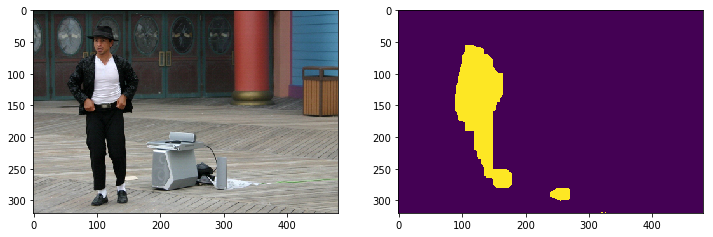

In [56]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)